In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from fitting import preds_targets_zn, get_range_dat, find_local_minima_maxima, envelope, polynomial, PCA_fit, calculate_PCA, get_nucl_range, mask_uncertainities, rms_val
import seaborn as sns
from scipy.signal import find_peaks
import gvar
from nuclr.train import Trainer

C:\tools\Anaconda3\envs\env_ai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sns.set()
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [4]:
model_path = "..\spiral"
trainer = Trainer.from_path(model_path)

No sn, sp or binding data, skipping leave one out


In [5]:
proton_embs, neutron_embs, task_embs = trainer.models[1].emb
proton_embs = proton_embs.weight.detach().cpu().numpy()
neutron_embs = neutron_embs.weight.detach().cpu().numpy()
task_embs = task_embs.weight.detach().cpu().numpy()

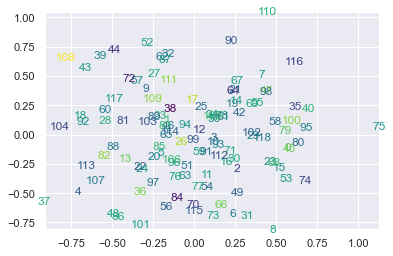

In [6]:
pca = PCA(n_components=5)

def show_plot(proton_embs):
    pca.fit(proton_embs)
    proton_embs_pca = pca.transform(proton_embs)

    cmap = plt.get_cmap('viridis', len(proton_embs_pca))
    pc3 = proton_embs_pca[:,2]
    pc3 = (pc3 - min(pc3)) / (max(pc3) - min(pc3))
    for i, point in enumerate(proton_embs_pca):
        c = cmap(pc3[i])
        plt.text(point[0], point[1], str(i), color=c, fontsize=12, verticalalignment='center', horizontalalignment='center')
    plt.xlim(min(proton_embs_pca[:,0]), max(proton_embs_pca[:,0]))
    plt.ylim(min(proton_embs_pca[:,1]), max(proton_embs_pca[:,1]))
    plt.show()
    return pca, proton_embs_pca

pca, embs_pca = show_plot(proton_embs)

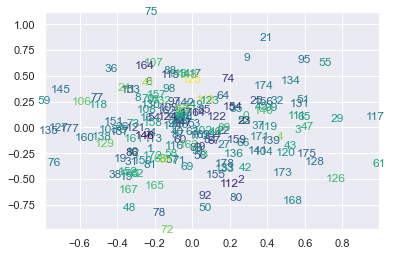

In [7]:
pca, embs_pca = show_plot(neutron_embs)

In [15]:
model = trainer.models[0].cpu()

task_names = list(trainer.data.output_map.keys())

In [16]:
magic_numbers = [2, 8, 20, 28, 50, 82, 126]

In [17]:
data = trainer.data

PCA: [0.01586163 0.01539611 0.01504701 0.01478617 0.01448327] 



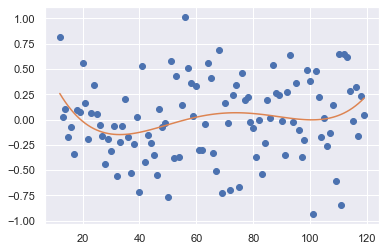

<Figure size 432x288 with 0 Axes>

In [18]:
#%% PCA FITS

pca_fit_nr = 4
fit_func = polynomial
n_fit = 4

Z = np.arange(1,torch.max(data[0][:, 0])+2,1)
N = np.arange(1,torch.max(data[0][:, 1])+2,1)

nucl = Z
embs = model.emb[0].weight.detach().cpu().numpy()

nucl_min = 12
nucl_max = N[-1]
parity = 'all'

Xfit, embs = get_nucl_range(nucl, embs, nucl_min, nucl_max, parity)
PCA_embs, embs = calculate_PCA(embs, True, 5)

# Xfit = np.repeat([embs[:, 0]], 2, axis=0).T

Yfit = PCA_embs[:, pca_fit_nr]
myfit = PCA_fit(Xfit,Yfit,fit_func,n_fit)

plt.plot(Xfit, PCA_embs[:, pca_fit_nr], "o")
plt.plot(Xfit,gvar.mean(fit_func(Xfit,myfit.p)))
plt.show()
plt.clf()
# plt.plot(Xfit,2*10**(-4)*(Xfit-70)**2+0.35*np.sin(0.2*Xfit-0.8)-0.8)

In [19]:
plt.rc('text', usetex=False)

In [20]:
# Z fixed and move along N see how BE changes.
task_name = "binding_semf"
task_idx = task_names.index(task_name)
protons = 12
max_neutrons = 120
inputs = torch.full((max_neutrons - 9, 3), protons)
inputs[:, 1] = torch.arange(9, max_neutrons)
inputs[:, 2] = task_idx
preds = model(inputs)

Text(0.5, 1.0, 'Binding Energy for Z=12')

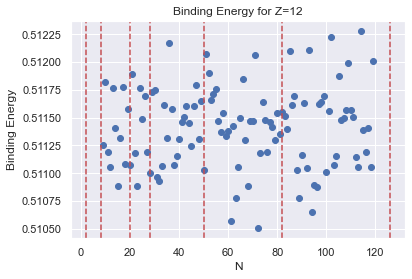

In [21]:
plt.scatter(inputs[:, 1], preds[:, task_idx].detach().cpu().numpy())
for magic_number in magic_numbers:
    plt.axvline(magic_number, color='r', linestyle='--')
plt.xlabel("N")
plt.ylabel("Binding Energy")
plt.title(f"Binding Energy for Z={protons}")